In [152]:
# Nescessary imports

%matplotlib inline

# supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # supress tensorflow warnings


# import libraries
import sys
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import rotate

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split

# set random seed
random.seed(42)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
%autoreload 2
from classes.data_wraper import Dataset
from classes.UNet import UNet
from classes.Experiment import Experiment
from classes.utils import plot_map, plot_radial_profile, apply_mask

In [154]:
# mount google drive if using google colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

In [155]:
if 'google.colab' in sys.modules:
    root_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Colab Notebooks')
else:
    root_dir = os.getcwd()

if 'google.colab' in sys.modules:
    data_dir = os.path.join(root_dir, 'data')
else:
    data_dir = os.path.join(root_dir, 'data')

In [156]:
paths = {
    'FOVfiting2' : os.path.join(data_dir, 'mapsCeline_FOVfitting_2_pol-60.mat'),
    '3quadrants2' : os.path.join(data_dir, 'mapsCeline_3quadrants_2_pol-60.mat'),
    'FOVfiting3' : os.path.join(data_dir, 'mapsCeline_FOVfitting_3_pol-60.mat'),
    '3quadrants3' : os.path.join(data_dir, 'mapsCeline_3quadrants_3_pol-60.mat'),
    'FOVfiting4' : os.path.join(data_dir, 'mapsCeline_FOVfitting_4_pol-60.mat'),
    '3quadrants4' : os.path.join(data_dir, 'mapsCeline_3quadrants_4_pol-60.mat'),
    'FOVfiting5' : os.path.join(data_dir, 'mapsCeline_FOVfitting_5_pol-60.mat'),
    '3quadrants5' : os.path.join(data_dir, 'mapsCeline_3quadrants_5_pol-60.mat'),
    'FOVfiting6' : os.path.join(data_dir, 'mapsCeline_FOVfitting_6_pol-60.mat'),
    '3quadrants6' : os.path.join(data_dir, 'mapsCeline_3quadrants_6_pol-60.mat'),   
    'FOVfiting9' : os.path.join(data_dir, 'mapsCeline_FOVfitting_9_pol-60.mat'),
    '3quadrants9' : os.path.join(data_dir, 'mapsCeline_3quadrants_9_pol-60.mat'),
    'FOVfiting9a' : os.path.join(data_dir, 'mapsCeline_FOVfitting_9a_polNP.mat'),
    '3quadrants9a' : os.path.join(data_dir, 'mapsCeline_3quadrants_9a_polNP.mat')
}

In [157]:
calibration_maps = [paths['FOVfiting2'], paths['3quadrants2']]
dataset = Dataset(calibration_maps)

Added data from c:\Users\f076048\Documents\Stage_CSL\data\mapsCeline_FOVfitting_2_pol-60.mat
New lenght: 297
Added data from c:\Users\f076048\Documents\Stage_CSL\data\mapsCeline_3quadrants_2_pol-60.mat
New lenght: 757


In [159]:
dataset.preprocess_data()
dataset.crop_data(128)

In [160]:
X = np.stack((dataset.map1_list, dataset.map2_list, dataset.map3_list), axis=-1)
y = dataset.combined_list
azimut = dataset.azimut_list

In [161]:
model = 'UNet'
if 'google.colab' in sys.modules:
    model_path = os.path.join(root_dir, model)
else:
    model_path = os.path.join(root_dir, 'models', model)
model_path_mae = model_path + '_mae'
unet = UNet(model_path=model_path_mae)

Loaded model from c:\Users\f076048\Documents\Stage_CSL\models\UNet_mae


1/1 [==============================] - 0s 279ms/step


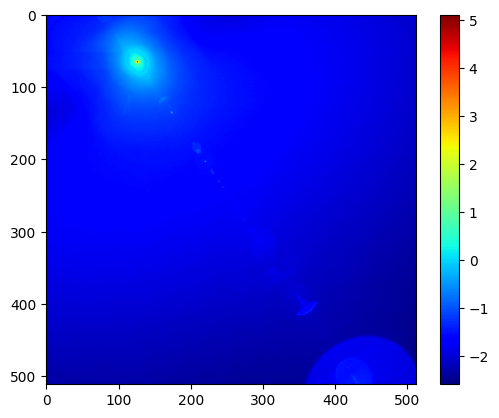

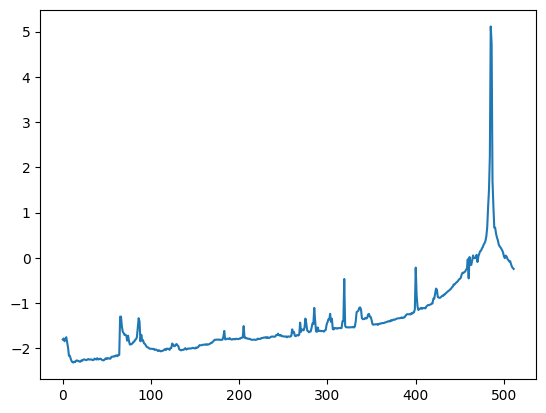

In [162]:
ind = random.randint(0, len(X)-1)
pred = unet.model.predict(X[ind:ind+1])[0, :, :, 0]
embeded = dataset.embed_map(pred, ind)
#embeded = dataset.rev_preprocess(embeded, ind)
plot_map(np.log10(embeded))
plot_radial_profile([np.log10(embeded)], azimut[ind])

In [163]:
# compute stray light and plot stray light as a function of the x and y coordinates
sl_list = []
x_list = []
y_list = []
preds = unet.model.predict(X)
for i, pred in enumerate(preds):
    pred = pred[:, :, 0]
    embeded = dataset.embed_map(pred, i)
    x, y, sl = dataset.compute_stray_light(embeded)
    sl_list.append(sl)
    x_list.append(x)
    y_list.append(y)

24/24 [==============================] - 79s 3s/step


In [174]:
# find the outliers (stray light > 1)
outliers = np.where(np.array(sl_list) > 1)[0]
print(outliers)
# remove outliers
sl_list = np.delete(sl_list, outliers)
x_list = np.delete(x_list, outliers)
y_list = np.delete(y_list, outliers)

[394 691]


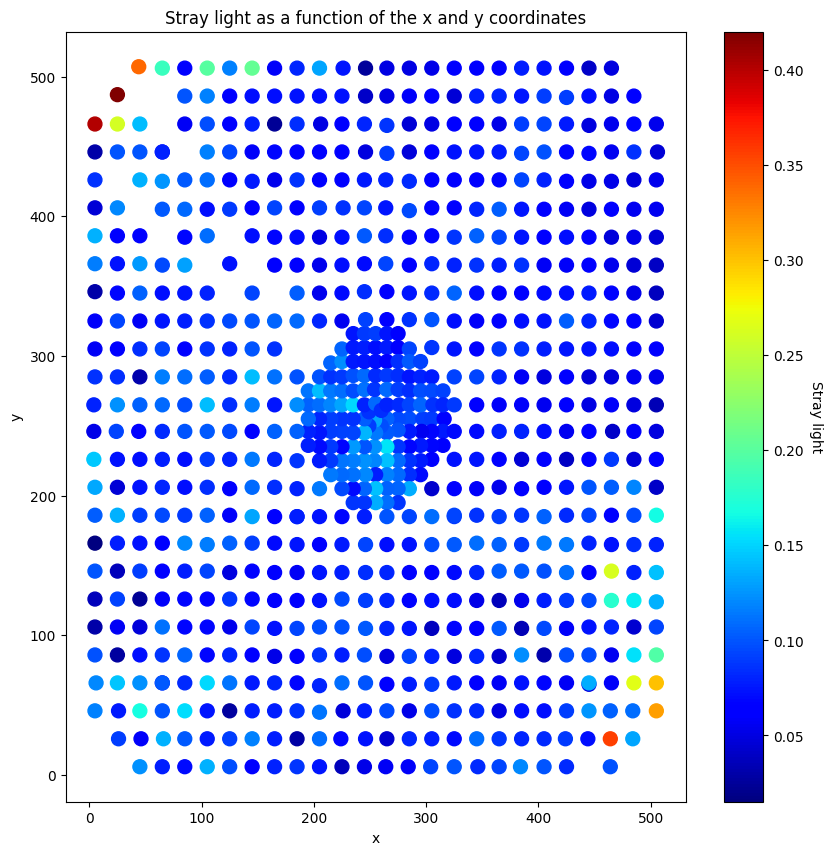

In [175]:
# scatter plot the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x_list, y_list, c=sl_list, cmap='jet', s=100)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Stray light as a function of the x and y coordinates')
# add a scaled colorbar
cbar = ax.figure.colorbar(ax.collections[0], ax=ax)
cbar.ax.set_ylabel('Stray light', rotation=-90, va="bottom")
plt.show()

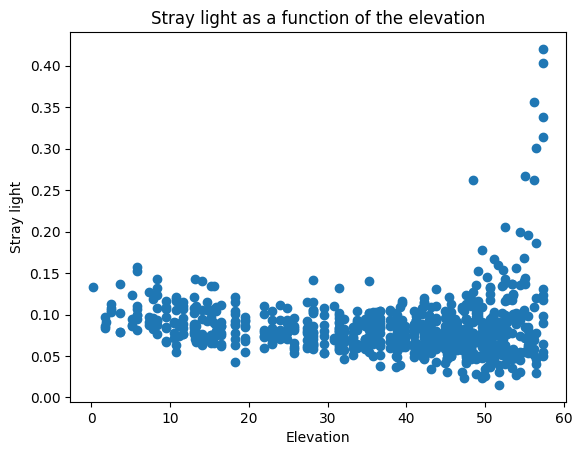

In [177]:
# plot the stray light as a function of the elevation
elevation = dataset.elevation_list.copy()
elevation = np.delete(elevation, outliers)
plt.plot(elevation, sl_list, 'o')
plt.xlabel('Elevation')
plt.ylabel('Stray light')
plt.title('Stray light as a function of the elevation')
plt.show()